In [1]:
from brian2 import *

seed(12345)

In [2]:
start_scope()

################################################################################
# Model parameters
################################################################################
### General parameters
duration = 1.0*second  # Total simulation time
sim_dt = 0.1*ms        # Integrator/sampling step
N_sst = 2              # Number of SST neurons (inhibitory)
N_pv = 2               # Number of PV neurons (inhibitory)
N_cc = 2               # Number of CC neurons (excitatory)
N_cs = 2               # Number of CS neurons (excitatory)

### Neuron parameters
tau_S   = 16*ms
tau_D   = 7*ms
tau_SST = 20*ms
tau_PV  = 10*ms
tau_E   = 5*ms           # Excitatory synaptic time constant
tau_I   = 10*ms          # Inhibitory synaptic time constant

C_S   = 370*pF
C_D   = 170*pF
C_SST = 100*pF
C_PV  = 100*pF

E_l  = -70*mV  # leak reversal potential
E_e  =   0*mV  # Excitatory synaptic reversal potential
E_i  = -80*mV  # Inhibitory synaptic reversal potential

V_t  = -50*mV  # spiking threashold
V_r  = E_l     # reset potential
c_d  = 2600*pA # 
g_s  = 1300*pA #
g_d  = 1200*pA #


# Sigmoid function params
E_d = -38*mV # position control of threshold
D_d =   6*mV # sharpness control of threshold 


### Synapse parameters
w_e = 0.05*nS          # Excitatory synaptic conductance
w_i = 1.0*nS           # Inhibitory synaptic conductance


### External Input
g = 1*pA
M = 1.05 
I_ext_sst = [g, g*M]    # external input SST
I_ext_pv = [0*pA, 0*pA] # external input PV
I_ext_cs = [0*pA, 0*pA] # external input CS
I_ext_cc = [0*pA, 0*pA] # external input CC

################################################################################

In [3]:
# TODO see how to reference this from equation 
@check_units(x=volt, result=volt)
def sigmoid(x):
    return 1/(1+exp(-(x-E_d)/D_d))

In [4]:
eqs_sst_inh = '''
    dv/dt=(-(v-E_l)/tau_SST + I/C_SST) : volt (unless refractory)
    
    dg_e/dt = -g_e*(1./tau_E) : siemens
    dg_i/dt = -g_i*(1./tau_I) : siemens
    
    I = I_external + I_syn : amp
    I_syn = g_e * (E_e - v) + g_i * (E_i - v) : amp
    I_external : amp
'''

eqs_pv_inh = '''
    dv/dt=(-(v-E_l)/tau_PV + I/C_PV) : volt (unless refractory)
    
    dg_e/dt = -g_e*(1./tau_E) : siemens
    dg_i/dt = -g_i*(1./tau_I) : siemens
    
    I = I_external + I_syn : amp
    I_syn = g_e * (E_e - v) + g_i * (E_i - v) : amp
    I_external : amp
'''

eqs_exc = '''
    dv_s/dt = (-(v_s-E_l)/tau_S + (g_s*(1/(1+exp(-(v_d-E_d)/D_d))) + I_s)/C_S) : volt (unless refractory)
    
    dg_es/dt = -g_es*(1./tau_E) : siemens
    dg_is/dt = -g_is*(1./tau_I) : siemens
    
    I_s = I_external + I_syn_s : amp
    I_syn_s = g_es * (E_e - v_s) + g_is * (E_i - v_s) : amp
    I_external : amp
    
    dv_d/dt = (-(v_d-E_l)/tau_D + (g_d*(1/(1+exp(-(v_d-E_d)/D_d))) + c_d*K + I_d)/C_D) : volt
    
    dg_ed/dt = -g_ed*(1./tau_E) : siemens
    dg_id/dt = -g_id*(1./tau_I) : siemens
    
    I_d = I_syn_d : amp
    I_syn_d = g_ed * (E_e - v_d) + g_id * (E_i - v_d) : amp
    K : 1
'''

In [5]:
# SST Neurons
sst_neurons = NeuronGroup(N_sst, model=eqs_sst_inh, threshold='v > V_t',
                          reset='v = E_l', refractory=8.3*ms, method='euler')
sst_neurons.set_states({'I_external': I_ext_sst })
sst_neurons.v = 'E_l + rand()*(V_t-E_l)'

# PV Neurons
pv_neurons = NeuronGroup(N_pv, model=eqs_pv_inh, threshold='v > V_t',
                          reset='v = E_l', refractory=8.3*ms, method='euler')
pv_neurons.set_states({'I_external': I_ext_pv })
pv_neurons.v = 'E_l + rand()*(V_t-E_l)'

# CS Neurons
cs_neurons = NeuronGroup(N_cs, model=eqs_exc, threshold='v_s > V_t',
                          reset='v_s = E_l', refractory=8.3*ms, method='euler')
cs_neurons.set_states({'I_external': I_ext_cs })
cs_neurons.v_s = 'E_l + rand()*(V_t-E_l)'
cs_neurons.v_d = -70*mV
cs_neurons.K = 1

# CC Neurons
cc_neurons = NeuronGroup(N_cc, model=eqs_exc, threshold='v_s > V_t',
                          reset='v_s = E_l', refractory=8.3*ms, method='euler')
cc_neurons.set_states({'I_external': I_ext_cc })
cc_neurons.v_s = 'E_l + rand()*(V_t-E_l)'
cc_neurons.v_d = -70*mV
cc_neurons.K = 1

In [6]:
# CS_CS 0, CS_SST 1, CS_PV 2, SST_CS 3, PV_CS 4, CC_CC 5, CC_SST 6, CC_PV 7, SST_CC 8, PV_CC 9, CC_CS 10, SST_PV 11, SST_SST 12, PV_PV 13, PV_SST 14, 
conn_probs = [1, 0.16, 0.23, 0.18, 0.52, 0.43, 0.06, 0.26, 0.22, 0.13, 0.38, 0.09, 0.29, 0.1, 0.5, 0.14]

# SST <=> PV
conn_SST_PV = Synapses(sst_neurons, pv_neurons, on_pre='g_i+=w_i', name='SST_PV') # inhibitory
conn_SST_PV.connect(p=conn_probs[11])
conn_PV_SST = Synapses(pv_neurons, sst_neurons, on_pre='g_i+=w_i', name='PV_SST') # inhibitory
conn_PV_SST.connect(p=conn_probs[14])

# PV <=> PYR soma
## target CS soma
conn_PV_CSsoma = Synapses(pv_neurons, cs_neurons, on_pre='g_is+=w_i', name='PV_CSsoma') # inhibitory
conn_PV_CSsoma.connect(p=conn_probs[4])
conn_CSsoma_PV = Synapses(cs_neurons, pv_neurons, on_pre='g_e+=w_e', name='CSsoma_PV') # excitatory
conn_CSsoma_PV.connect(p=conn_probs[2])

## target CC soma
conn_PV_CCsoma = Synapses(pv_neurons, cc_neurons, on_pre='g_is+=w_i', name='PV_CCsoma') # inhibitory 
conn_PV_CCsoma.connect(p=conn_probs[9])
conn_CCsoma_PV = Synapses(cc_neurons, pv_neurons, on_pre='g_e+=w_e', name='CCsoma_PV') # excitatory
conn_CCsoma_PV.connect(p=conn_probs[7])

# SST <=> PYR soma
## target CS soma
conn_SST_CSsoma = Synapses(sst_neurons, cs_neurons, on_pre='g_is+=w_i', name='SST_CSsoma') # inhibitory (optional connection)
conn_SST_CSsoma.connect(p=conn_probs[3])
conn_CSsoma_SST = Synapses(cs_neurons, sst_neurons, on_pre='g_e+=w_e', name='CSsoma_SST') # excitatory
conn_CSsoma_SST.connect(p=conn_probs[1])

## taget CC soma
conn_SST_CCsoma = Synapses(sst_neurons, cc_neurons, on_pre='g_is+=w_i', name='SST_CCsoma') # inhibitory (optional connection)
conn_SST_CCsoma.connect(p=conn_probs[8])
conn_CCsoma_SST = Synapses(cc_neurons, sst_neurons, on_pre='g_e+=w_e', name='CCsoma_SST') # excitatory
conn_CCsoma_SST.connect(p=conn_probs[6])

# CC => CS 
## target CS soma
conn_SST_CCdendrite = Synapses(cc_neurons, cs_neurons, on_pre='g_es+=w_e', name='CC_CSsoma') # excitatory
conn_SST_CCdendrite.connect(p=conn_probs[10])

# self connections
conn_CSsoma_CSsoma = Synapses(cs_neurons, cs_neurons, on_pre='g_es+=w_e', name='CSsoma_CSsoma') # excitatory
conn_CSsoma_CSsoma.connect(p=conn_probs[0])

conn_CCsoma_CCsoma = Synapses(cc_neurons, cc_neurons, on_pre='g_es+=w_e', name='CCsoma_CCsoma') # excitatory
conn_CCsoma_CCsoma.connect(p=conn_probs[5])

conn_SST_SST = Synapses(sst_neurons, sst_neurons, on_pre='g_i+=w_i', name='SST_SST')# inhibitory
conn_SST_SST.connect(p=conn_probs[12])

conn_PV_PV = Synapses(pv_neurons, pv_neurons, on_pre='g_i+=w_i', name='PV_PV')# inhibitory
conn_PV_PV.connect(p=conn_probs[13])


# SST => PYR dendrite
## target CS dendrite
conn_SST_CSdendrite = Synapses(sst_neurons, cs_neurons, on_pre='g_id+=w_i', name='SST_CSdendrite') # inhibitory
conn_SST_CSdendrite.connect(p=conn_probs[3]) # not sure about this here

## target CC dendrite
conn_SST_CCdendrite = Synapses(sst_neurons, cc_neurons, on_pre='g_id+=w_i', name='SST_CCdendrite') # inhibitory
conn_SST_CCdendrite.connect(p=conn_probs[8]) # not sure about this here



WARNING    Removing unsupported flag '-march=native' from compiler flags. [brian2.codegen.cpp_prefs]


In [7]:
# Record spikes of different neuron groups
spike_mon_sst = SpikeMonitor(sst_neurons)
spike_mon_pv = SpikeMonitor(pv_neurons)
spike_mon_cs = SpikeMonitor(cs_neurons)
spike_mon_c = SpikeMonitor(cc_neurons)

# Record conductances and membrane potential of neuron ni
state_mon_sst = StateMonitor(sst_neurons, ['v', 'g_e', 'g_i'], record=[0])
state_mon_pv = StateMonitor(pv_neurons, ['v', 'g_e', 'g_i'], record=[0])
state_mon_cs = StateMonitor(cs_neurons, ['v_s', 'v_d', 'g_es', 'g_is', 'g_ed', 'g_id'], record=[0])
state_mon_cc = StateMonitor(cc_neurons, ['v_s', 'v_d', 'g_es', 'g_is', 'g_ed', 'g_id'], record=[0])

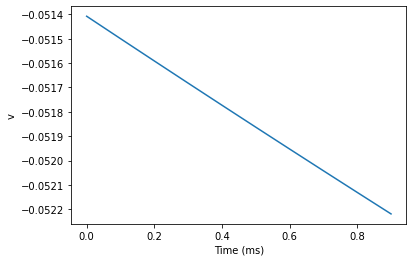

In [8]:
run(1*ms)

plot(state_mon_sst.t/ms, state_mon_sst.v[0])
for t in spike_mon_sst.t:
    axvline(t/ms, ls='--', c='C1', lw=3)
xlabel('Time (ms)')
ylabel('v');